In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

DATA_DIR = Path("/home/christian/Documents/research/MIST/mistsim/examples/20260215_for_christian")

## Raul's simulation

In [6]:
import h5py

def read_hdf5_convolution(path_file, print_key='no'):
	with h5py.File(path_file,'r') as hf:

		if print_key == 'yes':
			print([key for key in hf.keys()])

		hfX    = hf.get('lst')
		lst    = np.array(hfX)

		hfX    = hf.get('freq')
		freq   = np.array(hfX)
		
		hfX      = hf.get('ant_temp')
		ant_temp = np.array(hfX)			
	
	return lst, freq, ant_temp

path = Path(DATA_DIR) / Path("antenna_temperature_20260215_test1.hdf5")
lst, freqs, ant_temp_r = read_hdf5_convolution(path)

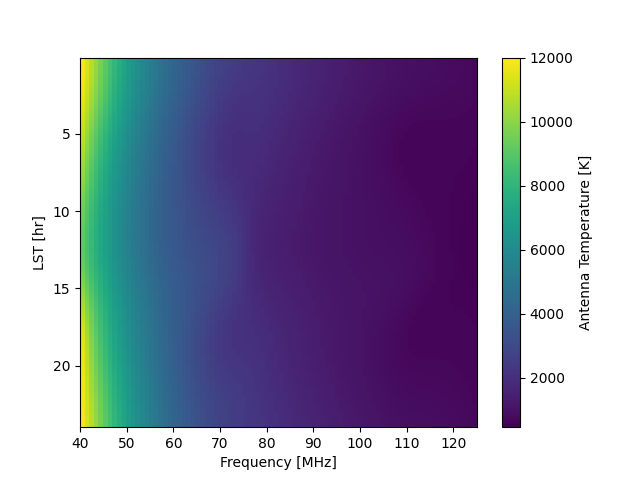

In [7]:
plt.figure()
plt.imshow(ant_temp_r, interpolation="none", aspect="auto", extent=[freqs[0], freqs[-1], lst[-1], lst[0]], vmin=450, vmax=12000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

## MISTSIM

In [8]:
from functools import partial

from astropy.coordinates import EarthLocation
from astropy.io import fits
from astropy.time import Time
import astropy.units as u
import croissant as cro
import croissant.jax as crojax
import healpy as hp
import jax
import jax.numpy as jnp
import s2fft

import mistsim as ms

In [9]:
NSIDE = 128
SIM_LMAX = 100

## Sky model

In [11]:
def load_haslam(fname="haslam408_ds_Remazeilles2014.fits"):
    fpath = DATA_DIR / Path(fname)
    with fits.open(fpath) as hdul:
        hdul.info()
        data = hdul[1].data
        header = hdul[1].header
    return data, header

def scale_map(m, freqs, beta=-2.55, f0=408, tcmb=2.725):
    mscale = m - tcmb
    scale = (freqs/f0)**beta
    return (m-tcmb)[None] * scale[:, None] + tcmb

In [12]:
data, hdr = load_haslam()
print(hdr)

Filename: /home/christian/Documents/research/MIST/mistsim/examples/20260215_for_christian/haslam408_ds_Remazeilles2014.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1                1 BinTableHDU     42   3072R x 1C   [1024E]   
XTENSION= 'BINTABLE'           /Written by IDL:  Mon Nov 17 15:44:43 2014       BITPIX  =                    8 /                                                NAXIS   =                    2 /Binary table                                    NAXIS1  =                 4096 /Number of bytes per row                         NAXIS2  =                 3072 /Number of rows                                  PCOUNT  =                    0 /Random parameter count                          GCOUNT  =                    1 /Group count                                     TFIELDS =                    1 /Number of columns                               TFORM1  = '1024E   '           /Real*4 (floating point)  

In [13]:
# map is in galactic, nside=512, ordring=ring
haslam = data["TEMPERATURE"].ravel()
haslam = hp.ud_grade(haslam, NSIDE, order_in="RING")
ga2eq = hp.Rotator(coord="gc")
haslam_eq = ga2eq.rotate_map_alms(haslam)

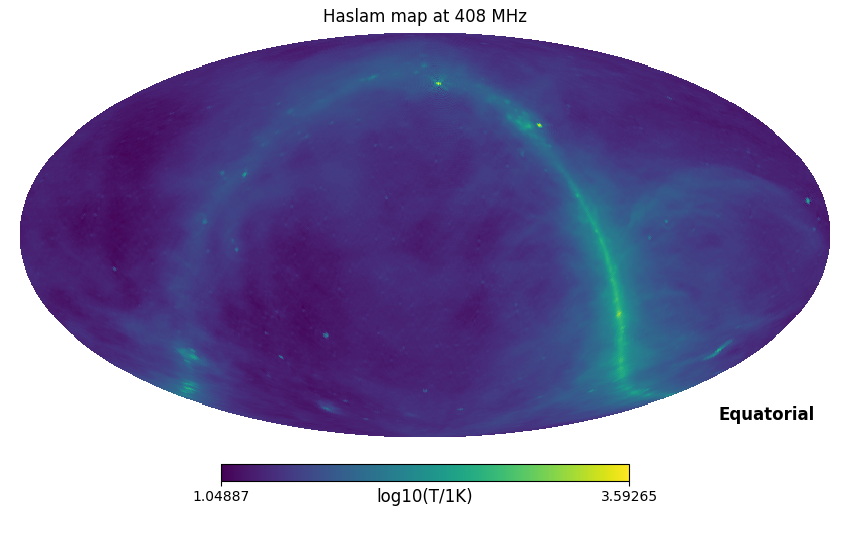

In [14]:
hp.mollview(np.log10(haslam_eq), coord="C", title="Haslam map at 408 MHz", cbar=True, unit="log10(T/1K)")
plt.show()

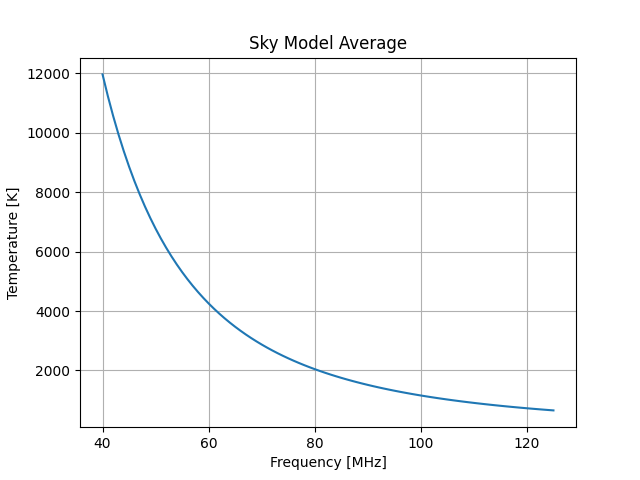

In [15]:
sky_model = scale_map(haslam_eq, freqs)

plt.figure()
plt.plot(freqs, sky_model.mean(axis=1))
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [K]")
plt.title("Sky Model Average")
plt.grid()
plt.show()

In [16]:
sky_L = 2 * NSIDE
sky2alm = partial(s2fft.forward, L=sky_L, spin=0, nside=NSIDE, sampling="healpix", method="jax_healpy", reality=True)
sky_alm = jnp.array([sky2alm(m) for m in sky_model])  # no vmap support for jax_healpy

# reduce lmax
sky_alm = crojax.alm.reduce_lmax(sky_alm, SIM_LMAX)
print(sky_alm.shape)

(86, 101, 201)


## Beam model

In [17]:
def load_beam(fname="beam.npz"):
    d = np.load(DATA_DIR / Path(fname))
    freqs = d["freqs"]
    phi = d["phi"]
    theta = d["theta"]
    gain = d["gain"]
    return freqs, phi, theta, gain

freqs_beam, phi, theta, gain_above = load_beam()

print(freqs_beam/1e6)
print(phi)
print(theta)
print(gain_above.shape)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.]
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.

Frequencies match: True
(86, 181, 360)


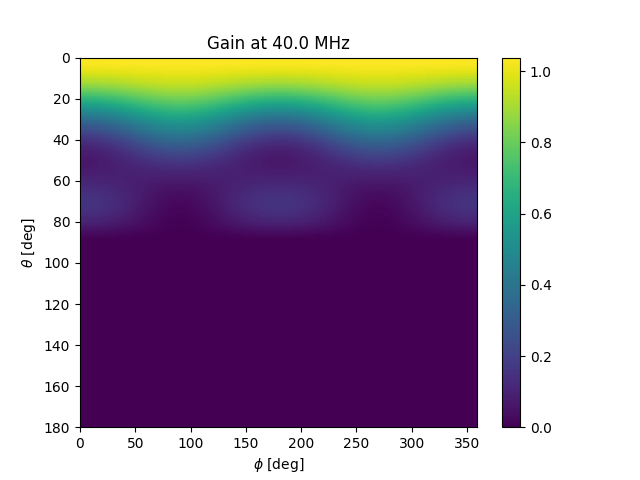

In [18]:
# need to restrict to same freq range as sky
fix = np.isin(freqs_beam/1e6, freqs)
gain_above = gain_above[fix]
freqs_beam = freqs_beam[fix]
print(f"Frequencies match: {np.allclose(freqs_beam/1e6, freqs)}")

# theta needs to go 0 to 180
gain_below = np.zeros_like(gain_above[:, :-1, :])
gain = np.concatenate((gain_above, gain_below), axis=1)
print(gain.shape)

theta = np.concatenate((theta, np.arange(91, 181)))


plt.figure()
plt.imshow(gain[0], aspect="auto", interpolation="none", extent=[0, 359, 180, 0])
plt.colorbar()
plt.title(f"Gain at {freqs[0]} MHz")
plt.xlabel("$\\phi$ [deg]")
plt.ylabel("$\\theta$ [deg]")
plt.show()

In [19]:
horizon = theta <= 80
horizon = horizon[:, None]
beam = ms.Beam(gain, freqs, horizon=horizon, lmax=SIM_LMAX)

## Simulator

In [34]:
u.

Unit("sday")

In [35]:
# define observation time and location, 0 to 24 hrs, 6 min bins
lon = -90.74750
lat = 79.41833
alt = 150
loc = EarthLocation.from_geodetic(lon, lat, height=alt)

t0 = Time("2022-07-17 00:00", location=loc)

def lst_to_time(lst_arr, t0=t0):
    """
    Convert array of LST to array of astropy Time objects for use with croissant

    Parameters
    ----------
    lst_arr : array_like
        List of LST in hrs
    t0 : Time
        Reference time.
    """
    lst_ref = t0.sidereal_time("mean").hour 
    delta = (lst_arr - lst_ref) /24 * u.sday
    times = t0 + delta
    return times

times = lst_to_time(lst)

In [39]:
sim = ms.Simulator(beam, sky_alm, times.jd, freqs, lon, lat, alt=alt, Tgnd=0)

In [40]:
tant = sim.sim()
fgnd = sim.beam.compute_fgnd()
tsky = ms.sim.correct_ground_loss(tant, fgnd, sim.Tgnd)

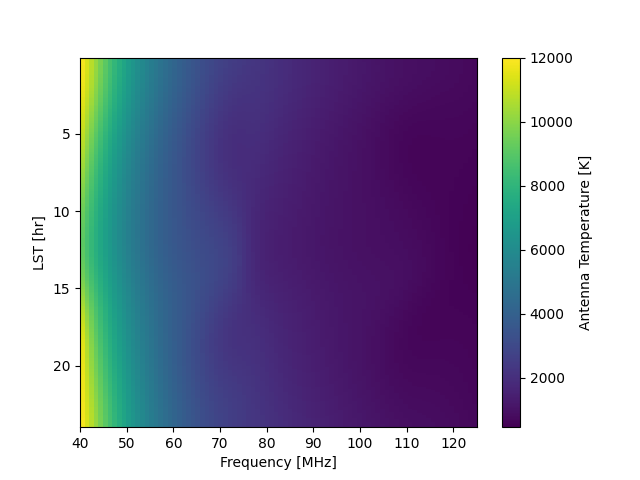

In [45]:
plt.figure()
plt.imshow(tsky, interpolation="none", aspect="auto", extent=[freqs[0], freqs[-1], lst[-1], lst[0]], vmin=450, vmax=12000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

## Compare Raul's sim with MISTSIM

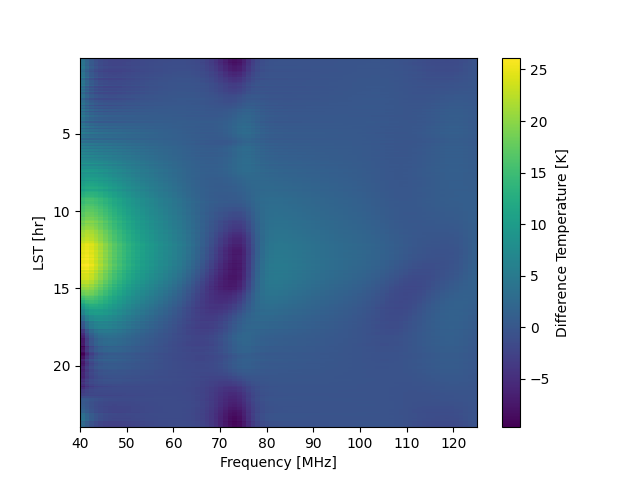

In [47]:
# ant_temp_r = raul's sim, tsky = mistsim
diff = ant_temp_r - tsky

plt.figure()
plt.imshow(diff, interpolation="none", aspect="auto", extent=[freqs[0], freqs[-1], lst[-1], lst[0]])
plt.colorbar(label="Difference Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()